# Setup

In [1]:
from fastai.vision.all import *
import os
from PIL import Image
import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score
from utilities import precision, recall, plot_metrics


/home/carljvh/mambaforge/envs/ahri_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Defining metric functions

In [2]:
# def precision(inp, targ):
#     preds = inp.argmax(dim=1)
#     return precision_score(targ, preds, average='weighted', zero_division=0)

# def recall(inp, targ):
#     preds = inp.argmax(dim=1)
#     return recall_score(targ, preds, average='weighted', zero_division=0)

    
# def plot_metrics(learn):
#     # Calculate the average training loss per epoch
#     num_batches_per_epoch = len(learn.recorder.losses) // len(learn.recorder.values)
#     train_loss_per_epoch = [np.mean(learn.recorder.losses[i * num_batches_per_epoch:(i + 1) * num_batches_per_epoch]).item() 
#                             for i in range(len(learn.recorder.values))]

#     # Extract validation loss, accuracy, precision, and recall from learn.recorder.values
#     valid_loss = [v[learn.recorder.metric_names.index('valid_loss') - 1] for v in learn.recorder.values]
#     accuracy = [v[learn.recorder.metric_names.index('accuracy') - 1] for v in learn.recorder.values]
#     # precision = [v[learn.recorder.metric_names.index('precision') - 1] for v in learn.recorder.values]
#     # recall = [v[learn.recorder.metric_names.index('recall') - 1] for v in learn.recorder.values]

#     # Create the first plot for training and validation loss
#     epochs = range(len(valid_loss))  # valid_loss is calculated per epoch

#     plt.figure(figsize=(12, 5))

#     # Plot training and validation loss
#     plt.subplot(1, 2, 1)  # First subplot (1 row, 2 columns, 1st plot)
#     plt.plot(epochs, train_loss_per_epoch, label='Training Loss', alpha=0.6)
#     plt.plot(epochs, valid_loss, label='Validation Loss')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.title('Training and Validation Loss over Epochs')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     # plt.plot(epochs, precision, label='Precision', color='green', marker='o')
#     # plt.plot(epochs, recall, label='Recall', color='red', marker='s')
#     plt.plot(epochs, accuracy, label='Accuracy', color='blue', marker='^')
    
    
#     plt.xlabel('Epochs')
#     plt.ylabel('Metrics')
#     plt.title('Accuracy and  Precision over Epochs')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

## Loading in the data

Here I added a setting for small sample (a selection of files from L1 for quicker traing)
* If you want to exepedite training on the smaller set, make this True, 
* for a better model trained on more images,make this False

In [2]:
SMALL_SAMPLE = False

In [3]:
try:
    import google.colab
    print("Running in Google Colab")
    COLAB = True
except ImportError:
    print("Not running in Google Colab")
    COLAB = False

if COLAB:
    os.makedirs('data', exist_ok=True)
    !git clone https://github.com/carlvh-wimmy/ahri_practicals
    !mv ahri_practicals/hiv_vision/data/training data/
    !mv ahri_practicals/hiv_vision/data/L1 data/

else:
    import timm

if SMALL_SAMPLE:
    path_training = Path('data/training')
else:
    path_training = Path('data/L1')

Not running in Google Colab


### Looking at some images

First we look at the images as they are saved. We'll look at 4 postive tests and 4 negative tests:

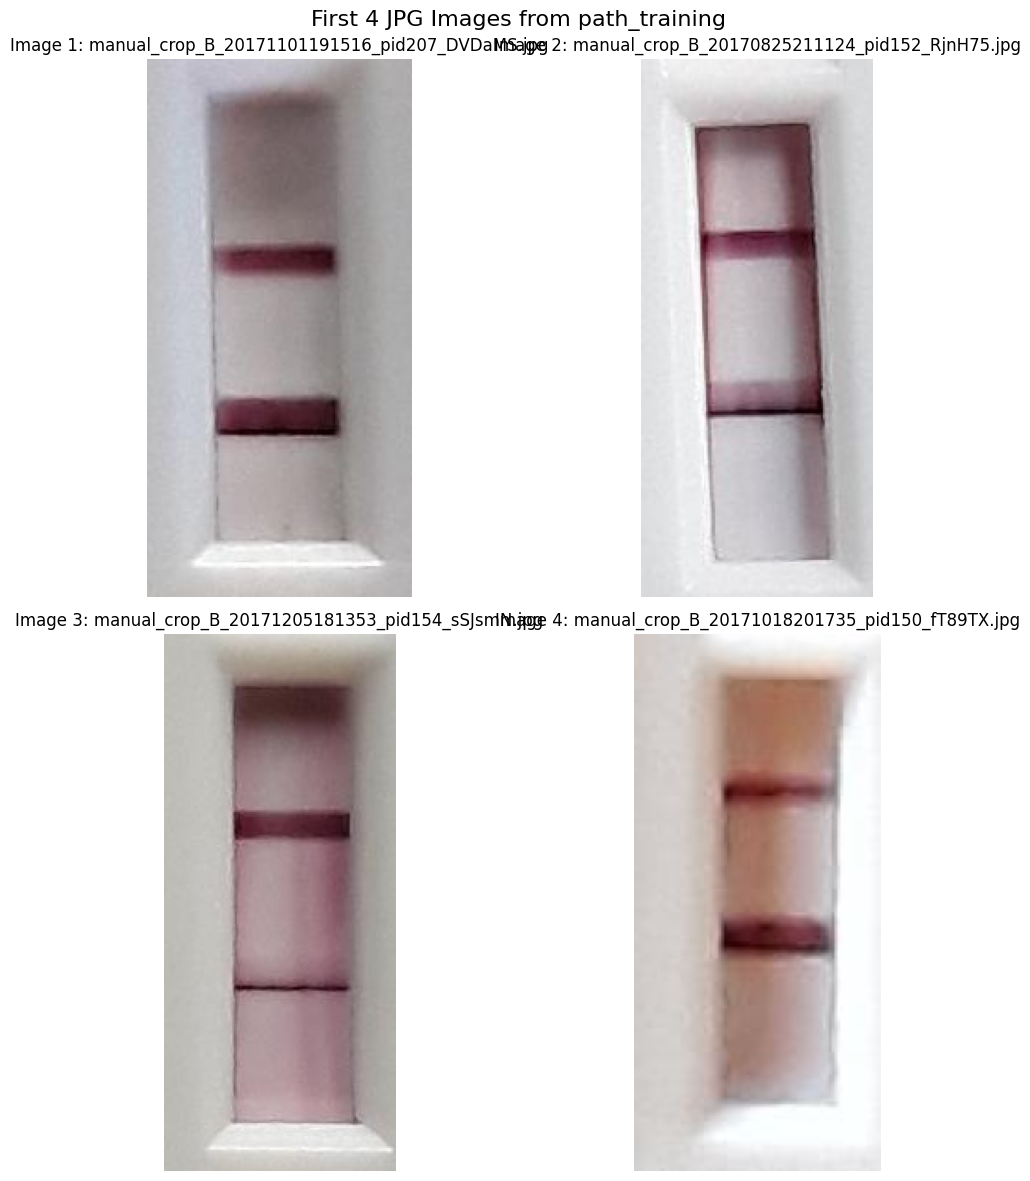

In [5]:
def display_first_4_jpgs(path):
    jpg_files = [f for f in os.listdir(path) if f.lower().endswith('.jpg')]
    first_4_jpgs = jpg_files[:4]

    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle("First 4 JPG Images from path_training", fontsize=16)

    for i, file in enumerate(first_4_jpgs):
        img_path = os.path.join(path, file)
        img = Image.open(img_path)
        ax = axes[i // 2, i % 2]
        ax.imshow(img)
        ax.set_title(f"Image {i+1}: {file}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

display_first_4_jpgs(os.path.join(path_training, 'pos'))

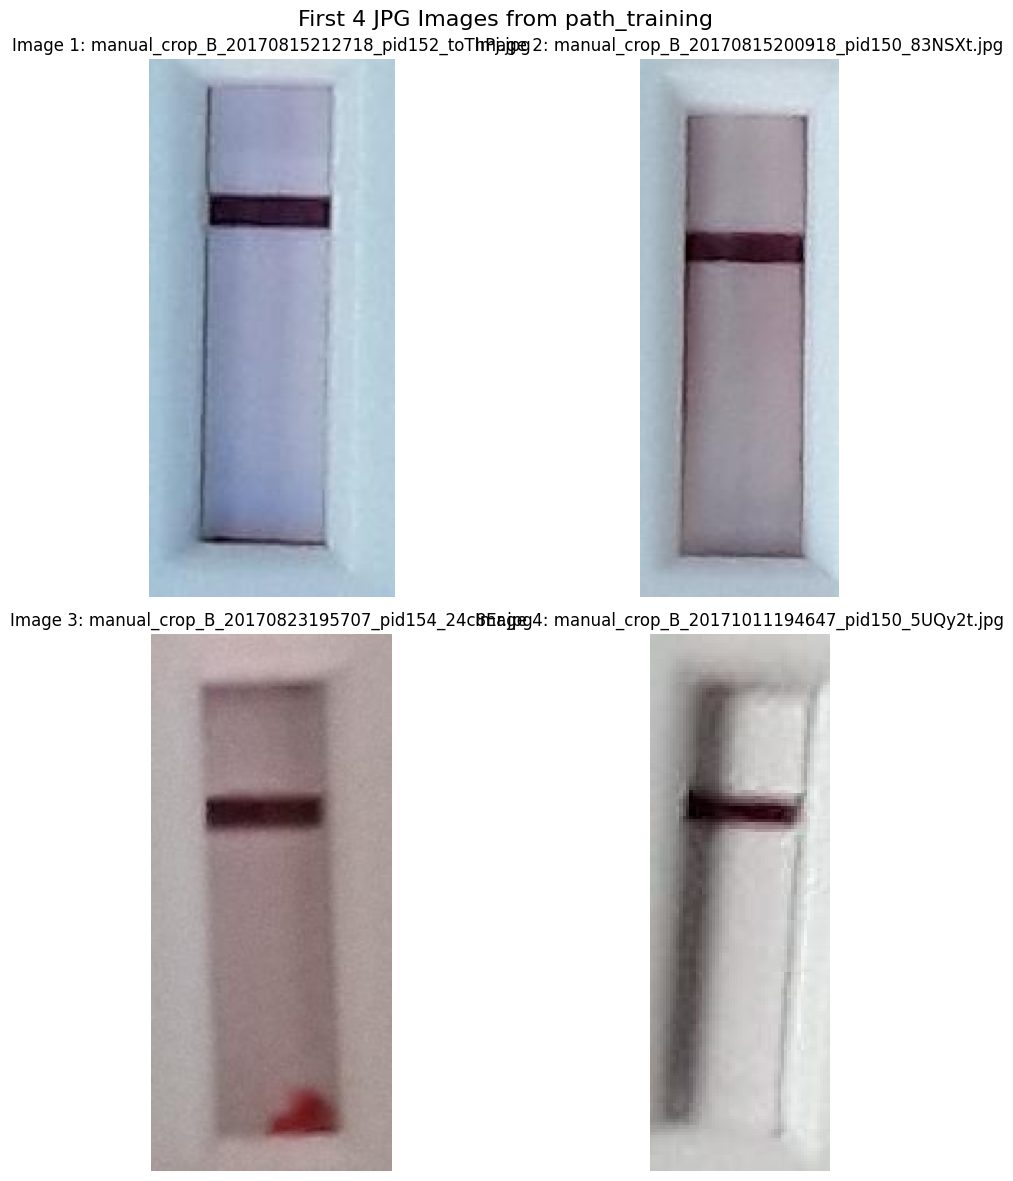

In [6]:
display_first_4_jpgs(os.path.join(path_training, 'neg'))

## Creating a dataloader

Here we load the files into a "dataloader", an object in Python that feeds the model the images it would need to train on. There are several choices we have to make at this point
* "valid_pct" is a parameter where we choose how large our validation set is: the training set consists of the images that the model looks at and updates its weights on, after an epoch (1 training run on the full training set) the model is tested on the validation set to validate how accurate it is.
* "seed" is a parameter we set to determine what "random" order the training and validation sets are chosen in and fed to the model. We set this model so that the results are more reproducible
* "item_tfms" is where we determine how the images get transformed prior to being fed to the model. we need to get all the images in the same size  and shape for this type of model. And if you reshape the images, you need to tell the model how it has to reshape the images. We'll look at examples of how this is done shortly.
* "batch_tfms" refers to the training time image augmentation, which are distortions we make to the image to make the training more generalisable
* "bs" is the batch size, a crucial parameter:

**Batch size and why it is important**:
The "batch size" refers to the number of images that pass through the model in a training run before the gradients are iteratively updated. Varying the batch size cause the following changes
* If the batch size is too large, your RAM or GPU memory can be overloaded causing your training run to crash
* Choosing a larger batch size, if the system doesn't crash, can speed up the training process, whilst training with a smaller batch size will generally take longer. 

Generally speaking aim for the largest batch size that does not crash your system

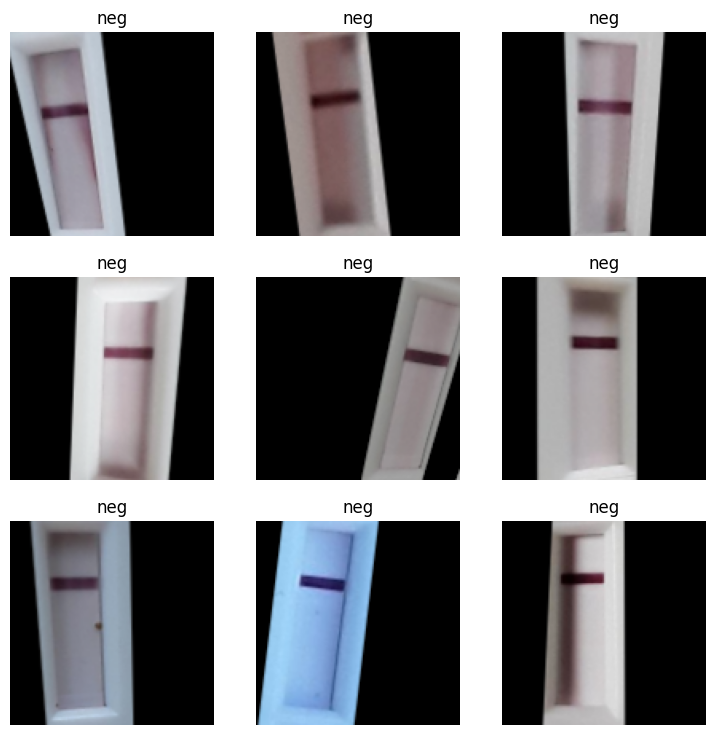

In [7]:
dls = ImageDataLoaders.from_folder(
    path_training,    # Path to the folder containing 'pos' and 'neg'
    valid_pct=0.2,    # Use 20% of the data for validation
    seed=42,          # Ensure reproducibility by setting a seed
    item_tfms=Resize(128, method='pad', pad_mode='zeros'),  # Resize images to 224x224 for training
    batch_tfms=aug_transforms(),  # Apply default image augmentations
    bs=32  # Batch size (you can adjust based on available GPU memory)
)

dls.show_batch()

In [8]:
# Here we check how many images are in the training and validation sets
print(f"There are {len(dls.train_ds)} entries in the training set\nand {len(dls.valid_ds)} in the validation set\n")

# And check the balance of the training and validation sets
train_classes = [int(dls.train_ds[i][1]) for i in range(len(dls.train_ds))]
train_class_0_count = train_classes.count(0)  # Assuming 0 is one of the classes
train_class_1_count = train_classes.count(1)  # Assuming 1 is the other class
print(f"Training set class distribution: Negative: {train_class_0_count}, Positive: {train_class_1_count}\nPositives are {train_class_1_count / train_class_0_count} of total.\n")

valid_classes = [int(dls.valid_ds[i][1]) for i in range(len(dls.valid_ds))]
valid_class_0_count = valid_classes.count(0)
valid_class_1_count = valid_classes.count(1)
print(f"Validation set class distribution: Negative: {valid_class_0_count}, Positive: {valid_class_1_count}\nPositives are {valid_class_1_count / valid_class_0_count} of total.")

There are 3616 entries in the training set
and 904 in the validation set

Training set class distribution: Negative: 3335, Positive: 281
Positives are 0.08425787106446776 of total.

Validation set class distribution: Negative: 836, Positive: 68
Positives are 0.08133971291866028 of total.


Here I have opted to pad the images with "zeros", meaning black. I do not want to crop the images as the test lines can potentially be cropped out. And I also do not want to mirror the images as that does not give a good representation of what is happening in the picture. 

In this batch we can see that the images have been deformed. This is done as part of the aug_transforms() function in fastai where data augmentation is done

Here are some other ways in which the images can be preprocessed: 

### Alternative preprocessing steps

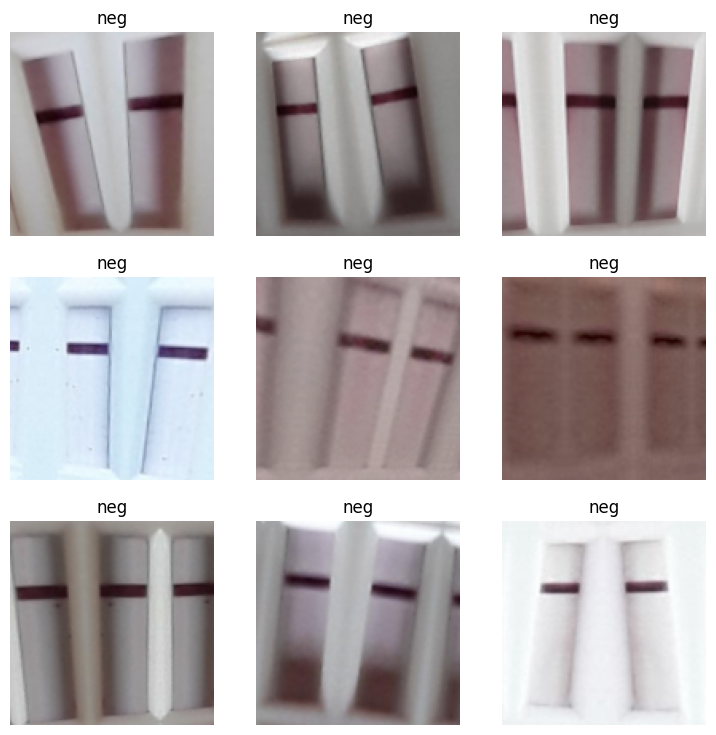

In [9]:
# Padding the images with mirror images
dls = ImageDataLoaders.from_folder(
    path_training,  
    valid_pct=0.2,  
    seed=42,    
    item_tfms=Resize(128, method='pad', pad_mode='reflection'), 
    batch_tfms=aug_transforms(), 
    bs=32 
)
dls.show_batch()

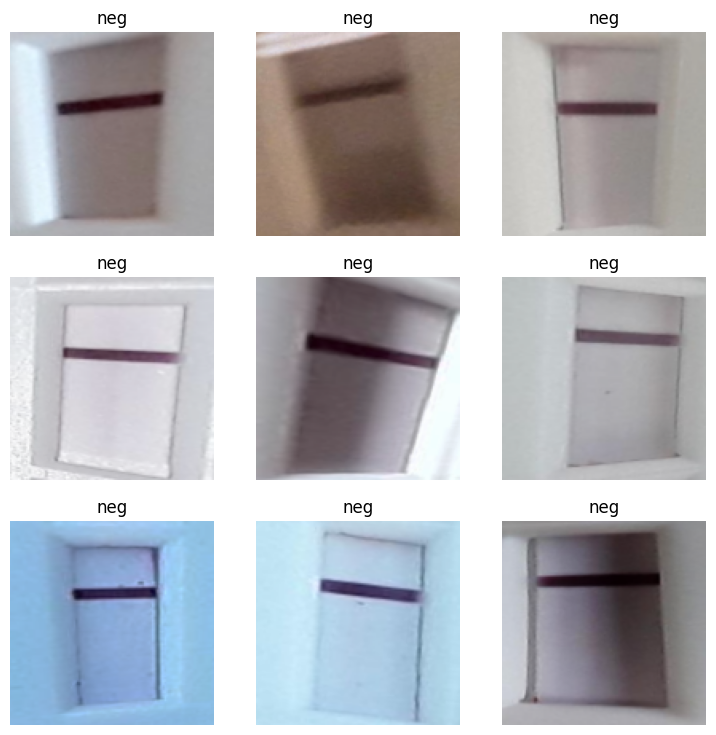

In [10]:
# Stretching out the image to fill the square
dls = ImageDataLoaders.from_folder(
    path_training,  
    valid_pct=0.2,  
    seed=42,      
    item_tfms=Resize(128, method='squish'),  
    batch_tfms=aug_transforms(),  
    bs=32  
)
dls.show_batch()

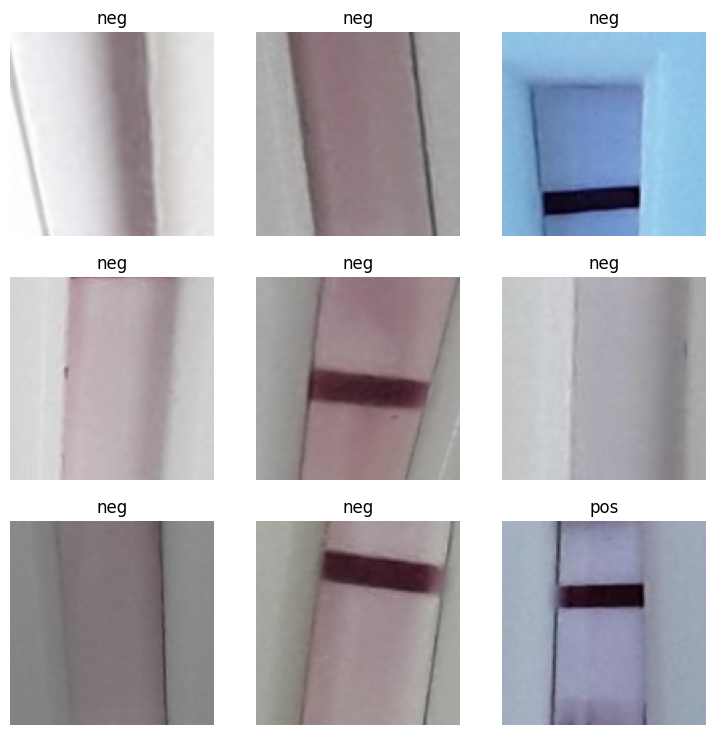

In [11]:
# Cropping the images
dls = ImageDataLoaders.from_folder(
    path_training,    
    valid_pct=0.2,    
    seed=42,          
    item_tfms=Resize(128, method='crop'),  
    batch_tfms=aug_transforms(),  
    bs=32  
)
dls.show_batch()

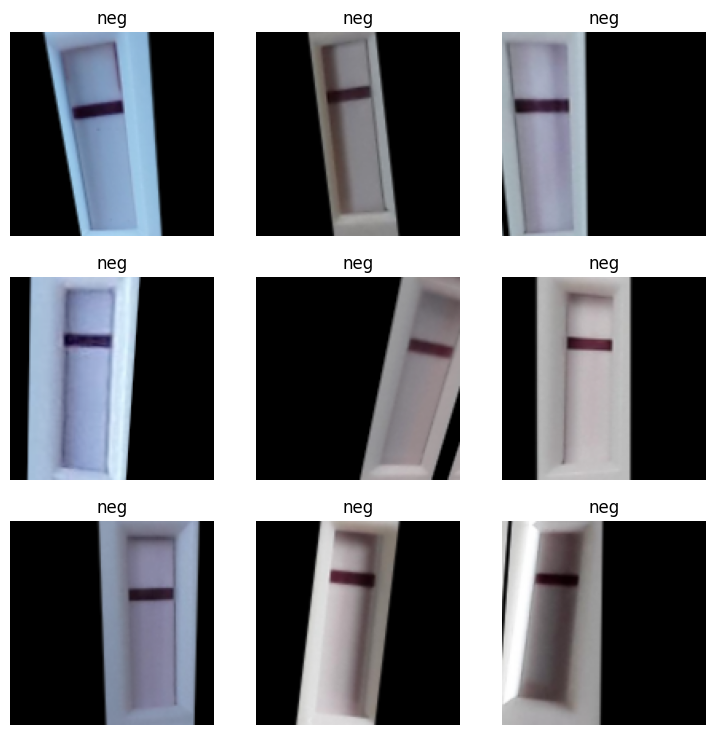

In [12]:
# Changing our dataloaders back to what we originally wanted
dls = ImageDataLoaders.from_folder(
    path_training,  
    valid_pct=0.2,  
    seed=42,     
    item_tfms=Resize(128, method='pad', pad_mode='zeros'), 
    batch_tfms=aug_transforms(),  
    bs=32  
)

dls.show_batch()

# Training the model

In this example we not really training the model completely from scratch. We will be selecting a pre-trained model from the TIMM library of pre-trained pytorch models. This means that we load a model that has already undergone some training on different images, then we strip away the last layers of the neural network that make the model specific to the previous images. And then we train the model on our new set of images, in this case our HIV tests.

I have selected a very humble small model that can run with ease on a CPU and we can see relatively good results

In [4]:
if COLAB:
    chosen_model = resnet18
else:
    chosen_model = 'mobilenetv3_small_100'
# chosen_model = resnet18

## Training the first model

Now we train the first model!

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.553058,0.307956,0.870575,0.941458,0.870575,00:46
1,0.284041,0.112430,0.952434,0.945339,0.952434,00:35
2,0.176344,0.062045,0.986726,0.990843,0.986726,00:33


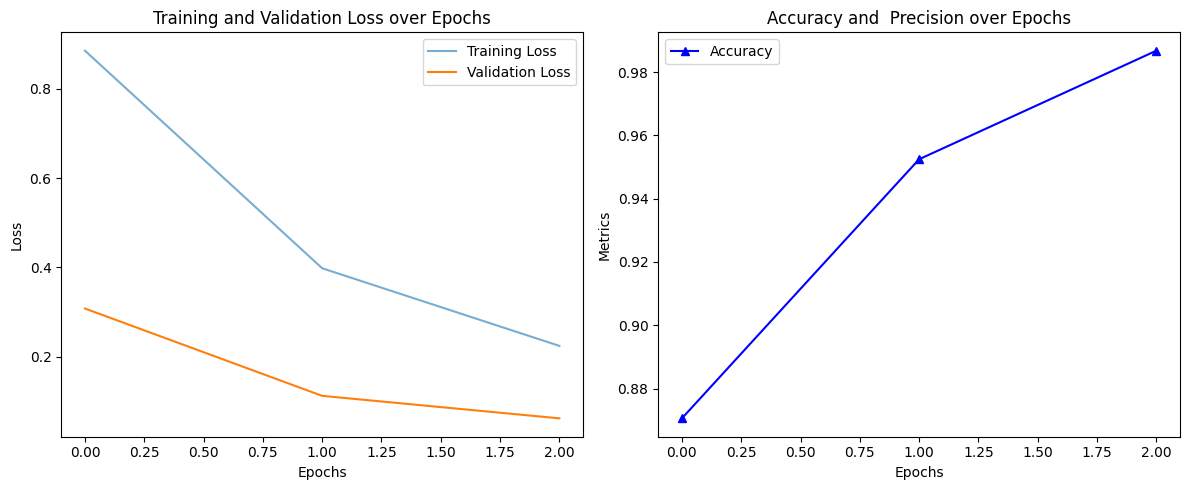

In [14]:
learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall])
learn.fit(3)
plot_metrics(learn)

## Looking at the model details

In [15]:
print(learn.model)

Sequential(
  (0): TimmBody(
    (model): MobileNetV3(
      (conv_stem): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Hardswish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
            (bn1): BatchNormAct2d(
              16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): ReLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): ReLU(inplace=True)
              (conv_expand): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
              (ga

In [16]:
print(learn.opt_func)

<function Adam at 0x7f09c7761080>


In [17]:
print(learn.loss_func)

FlattenedLoss of CrossEntropyLoss()


## Experimenting with learning rates and training regimes

Learning rate refers to the magnitude of the correction of the gradients in the model. A learning rate that is too large will have poor results, as it cannot converge on a good answer. A learning rate that is too small will make very slow progress towards fitting a good model and can get stuck in local minima.

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.713713,2.617040,0.814159,0.954176,0.814159,00:34
1,0.256261,0.000010,1.000000,1.000000,1.000000,00:36
2,0.214288,0.013835,0.997788,0.999263,0.997788,00:35
3,0.306799,0.063355,0.998894,0.998932,0.998894,00:33
4,0.474763,0.036311,0.997788,0.998197,0.997788,00:34


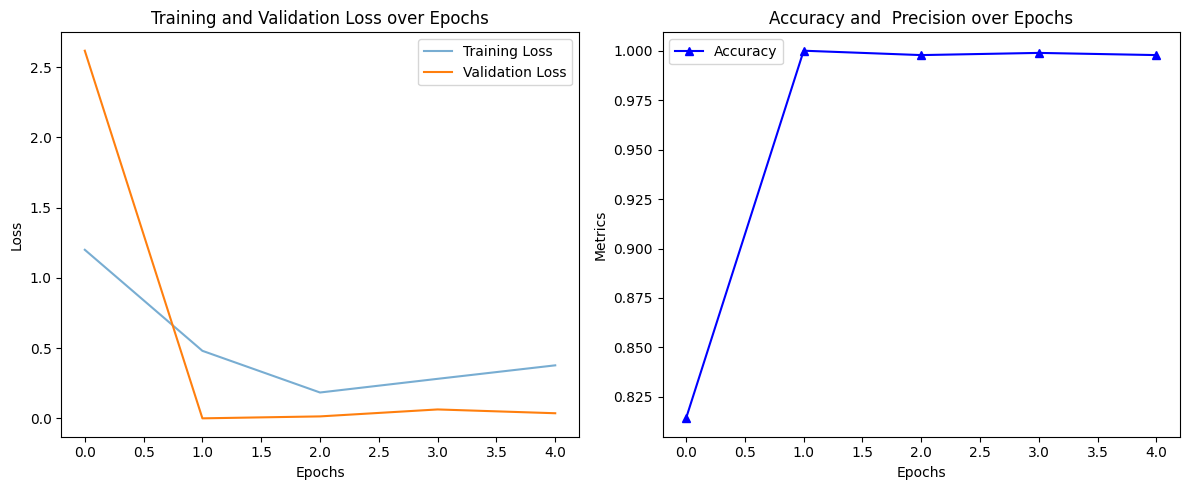

In [18]:
# A learning rate of 0.05 is a reasonable learning rate
learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall])
learn.fit(5, lr=0.05)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,86.933182,101247.734375,0.888274,0.879467,0.888274,00:33
1,37.548542,48.277195,0.925885,0.868357,0.925885,00:33
2,54.430523,20998176.000000,0.556416,0.845738,0.556416,00:33
3,53.116127,131.999786,0.805310,0.941935,0.805310,00:34
4,42.114735,28242090.000000,0.925885,0.879657,0.925885,00:33


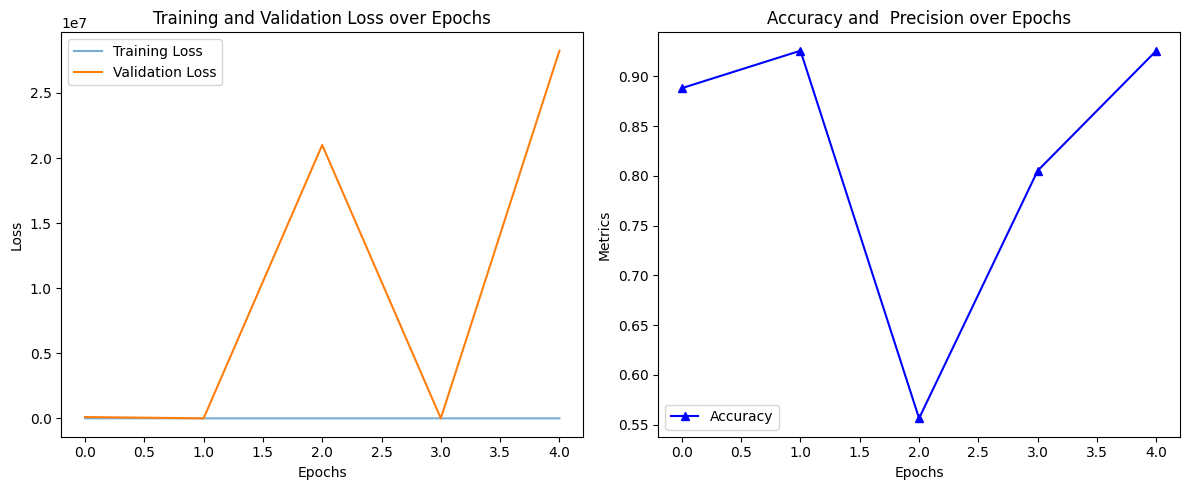

In [19]:
# A learning rate of 1 is way too large and will result in a poor model
learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall])
learn.fit(5, lr=1)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,1.237590,0.829368,0.511062,0.883472,0.511062,00:34
1,1.197758,0.726064,0.589602,0.895270,0.589602,00:34
2,1.160748,0.731560,0.584071,0.890069,0.584071,00:33
3,1.100063,0.700135,0.612832,0.898381,0.612832,00:33
4,1.036571,0.710917,0.612832,0.903323,0.612832,00:33


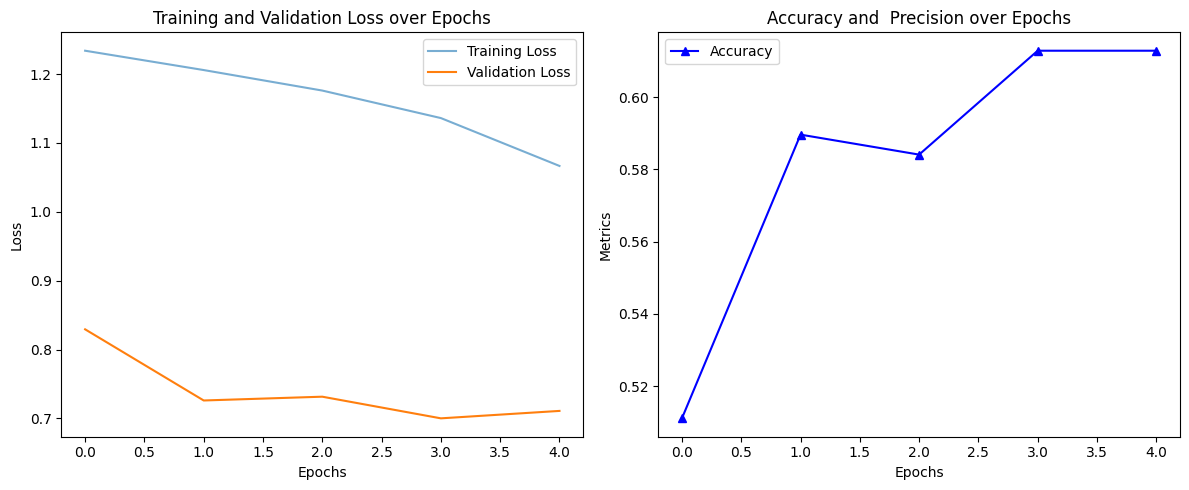

In [20]:
# A learning rate of 0.00001 is probably too small and will also result in a poor model
learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall])
learn.fit(5, lr=0.00001)
plot_metrics(learn)

/home/carljvh/mambaforge/envs/ahri_env/lib/python3.12/site-packages/fastai/learner.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(file, map_location

SuggestedLRs(valley=0.005248074419796467, slide=0.009120108559727669)

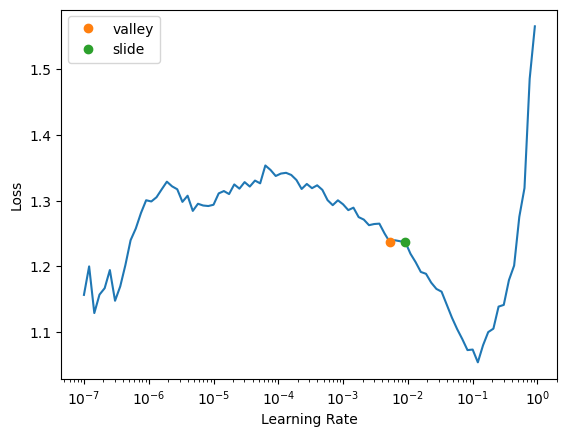

In [21]:
# With the FastAI API we can use the learning rate finder lr_find() to find a learning rate that is appropriate
learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall])
learn.lr_find(suggest_funcs=[valley, slide])

## Using a more sophisticated training regime

If, instead of .fit() we use .fine_tune(), several steps are added to the process and the learning rate starts low, is rapidly increased and then decreased. The idea is to rapidly converge on a good fit initially and then slow the process down with the lower learning rate adjustments with finer detail become more important.

epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.741264,0.417760,0.806416,0.913990,0.806416,00:33


epoch,train_loss,valid_loss,accuracy,precision,recall,time
0,0.313317,0.110028,0.957965,0.959110,0.957965,00:42
1,0.222516,0.091059,0.972345,0.981883,0.972345,00:41
2,0.130599,0.049150,0.988938,0.991226,0.988938,00:41
3,0.078792,0.034951,0.988938,0.990803,0.988938,00:41
4,0.070875,0.025631,0.993363,0.993569,0.993363,00:41


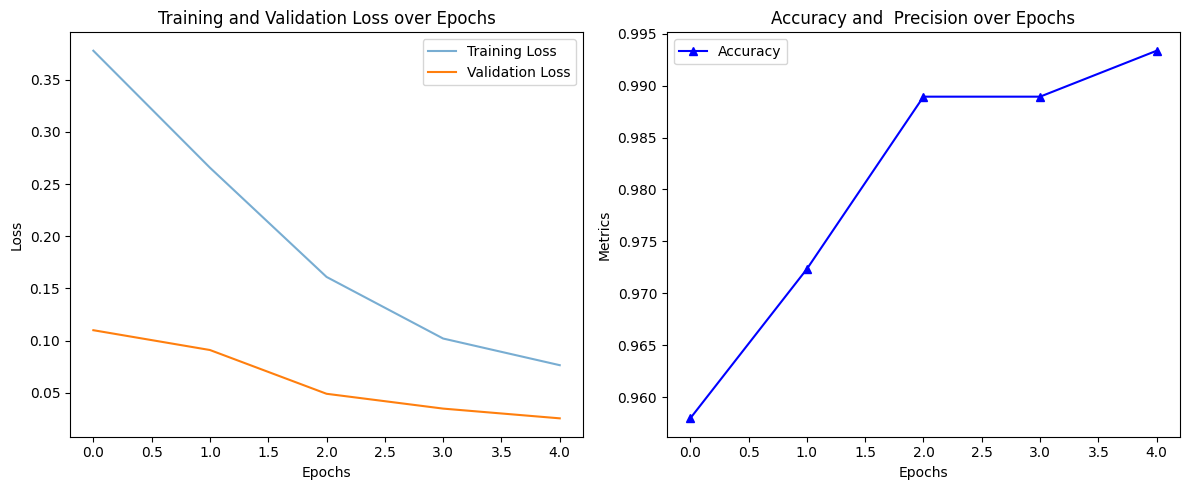

In [22]:
learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall])
learn.fine_tune(5)
plot_metrics(learn)

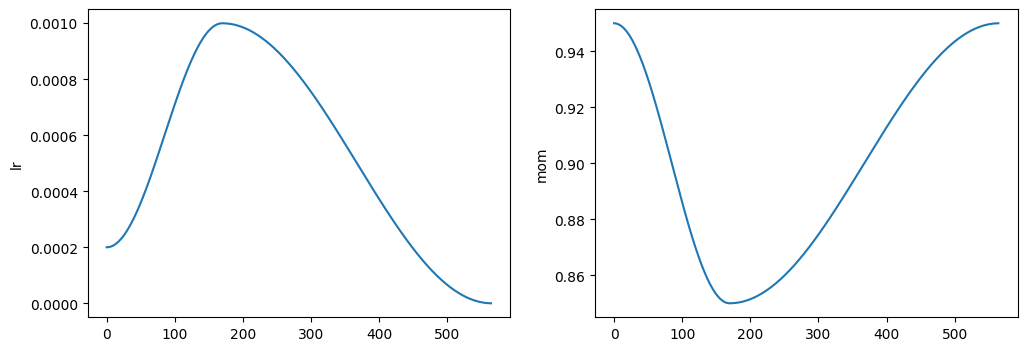

In [23]:
learn.recorder.plot_sched()

## Interpreting the model's results

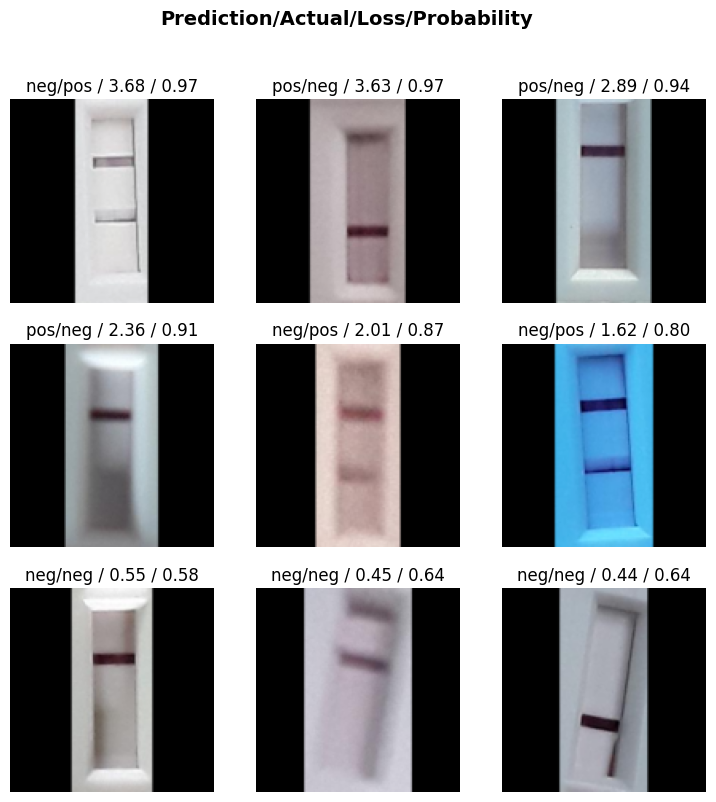

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(k=9, nrows=3)

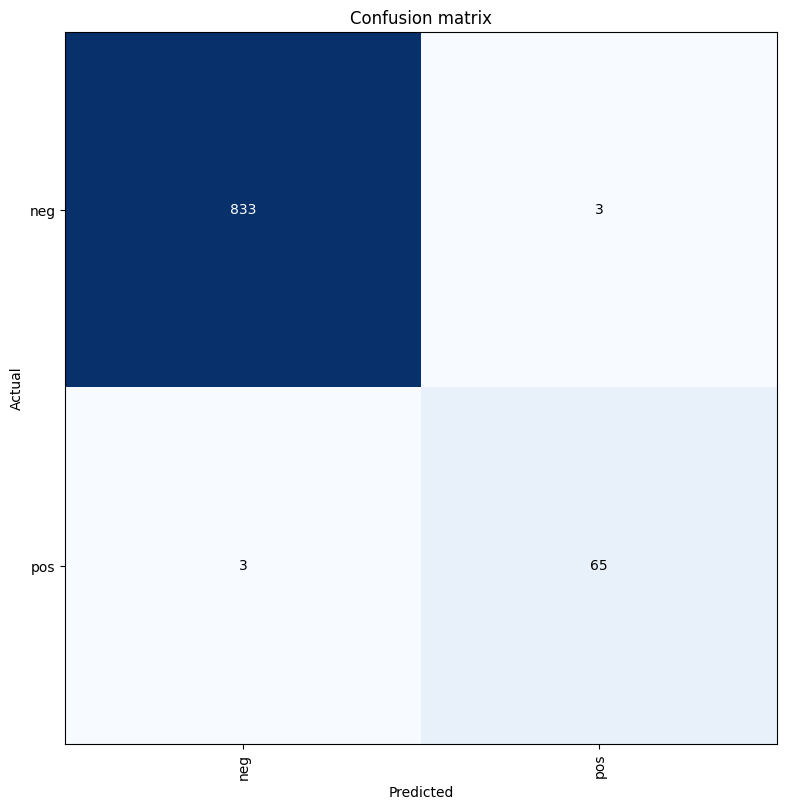

In [25]:
interp.plot_confusion_matrix(figsize=(8,8))

## Trying out different models

In [26]:
# chosen_model = resnet34
# learn = vision_learner(dls, chosen_model, metrics=[accuracy, precision, recall]))
# learn.fine_tune(4)
# plot_metrics(learn)

# Training on more data


In [5]:
path_l1 = Path('data/L1')  # Path to 'pos' and 'neg' in L1
path_s2 = Path('data/S2')  # Path to 'pos' and 'neg' in S2
combined_path = Path('data/combined')  # Path to where you want to combine both datasets

os.makedirs(combined_path / 'pos', exist_ok=True)
os.makedirs(combined_path / 'neg', exist_ok=True)

def is_valid_file(img_path):
    return img_path.is_file() and img_path.suffix.lower() == '.jpg' and ':Zone.Identifier' not in img_path.name


# Symlink images from L1 to combined using absolute paths
for folder in ['pos', 'neg']:
    for img in (path_l1 / folder).glob('*'):
        if is_valid_file(img):
            try:
                os.symlink(img.resolve(), combined_path / folder / img.name)
            except FileExistsError:
                pass  # Skip if the file already exists

# Symlink images from S2 to combined using absolute paths
for folder in ['pos', 'neg']:
    for img in (path_s2 / folder).glob('*'):
        if is_valid_file(img):
            try:
                os.symlink(img.resolve(), combined_path / folder / img.name)
            except FileExistsError:
                pass  # Skip if the file already exists

In [6]:
dls = ImageDataLoaders.from_folder(
    combined_path,    # Combined path containing 'pos' and 'neg'
    valid_pct=0.2,    # Use 20% of the data for validation
    seed=42,          # Ensure reproducibility by setting a seed
    item_tfms=Resize(128, method='pad', pad_mode='zeros'),  # Resize images to 128x128
    batch_tfms=aug_transforms(),  # Apply default image augmentations
    bs=32  # Batch size
)

In [7]:
print(len(dls.train_ds), len(dls.valid_ds))

5544 1386


epoch,train_loss,valid_loss,accuracy,time
0,0.570647,0.491650,0.779221,01:02


epoch,train_loss,valid_loss,accuracy,time
0,0.253232,0.174771,0.940115,01:07
1,0.187575,0.117374,0.963203,01:06
2,0.140384,0.068274,0.981963,01:08
3,0.094210,0.068533,0.977633,01:10
4,0.083273,0.049067,0.985570,01:09


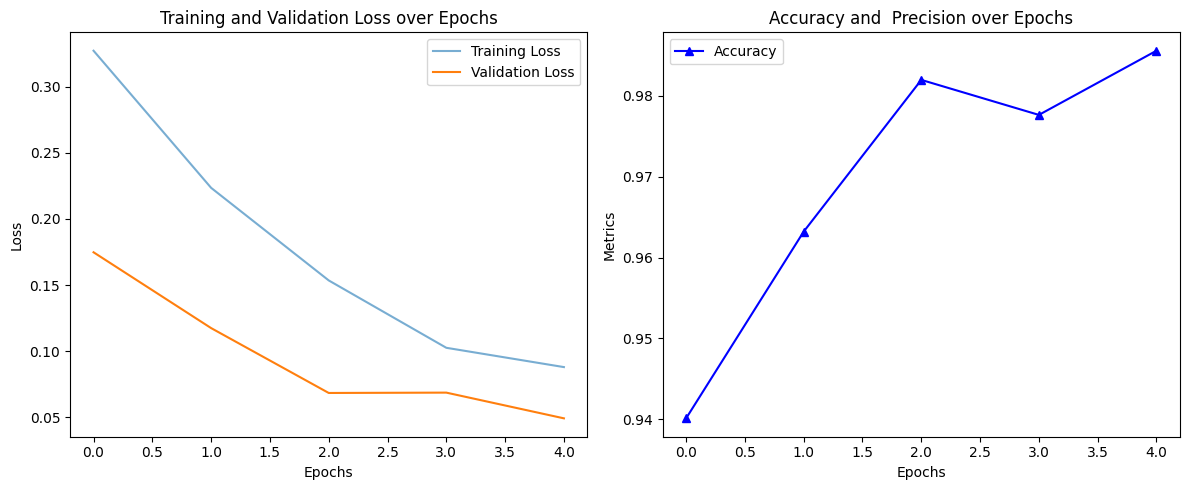

In [8]:
# chosen_model = resnet18

learn = vision_learner(dls, chosen_model, metrics=accuracy)
learn.fine_tune(5)
plot_metrics(learn)

In [10]:
learn.fine_tune(8)
plot_metrics(learn)

epoch,train_loss,valid_loss,accuracy,time


# Inference on other folders

In [15]:
# # Function to get only .jpg images from the 'pos' and 'neg' subfolders
# def get_images_from_folder(folder_path, n=50):
#     pos_images = (Path(folder_path) / 'pos').glob('*.jpg')
#     neg_images = (Path(folder_path) / 'neg').glob('*.jpg')
    
#     pos_images = list(pos_images)  # Convert generator to list
#     neg_images = list(neg_images)
    
#     return random.sample(pos_images, n//2) + random.sample(neg_images, n//2)

# # Function to run inference and calculate accuracy
# def test_inference_on_folder(folder):
#     images = get_images_from_folder(folder)
#     correct = 0
#     total = len(images)

#     for img_path in images:
#         # Load image
#         img = PILImage.create(img_path)
        
#         # Get true label from folder name (pos -> 1, neg -> 0)
#         true_label = 1 if img_path.parent.name == 'pos' else 0
        
#         # Run inference
#         pred_class, pred_idx, probs = learn.predict(img)
        
#         # Check if prediction matches the true label
#         if pred_idx == true_label:
#             correct += 1
    
#     # Calculate accuracy
#     accuracy = correct / total
#     print(f"Accuracy on {folder}: {accuracy * 100:.2f}%")

# # Test on each folder: data/L2, data/S1, data/S2
# folders = ['data/L1', 'data/L2', 'data/S1', 'data/S2']
# for folder in folders:
#     test_inference_on_folder(folder)

In [9]:
path_s1 = Path('data/S1')
# Set up the test DataLoader for the 'S1' folder
test_dl = learn.dls.test_dl(get_image_files(path_s1), with_labels=True)

# Get predictions and targets from the test set
preds, targs = learn.get_preds(dl=test_dl)

# Calculate accuracy
acc = accuracy(preds, targs)
print(f"Accuracy on inference set: {acc}")

Accuracy on inference set: TensorBase(0.9149)


# Homework

Now try the following:
* Rewrite the code to make the dataloaders, except using one of the other folders to train
* Try using different models, other than resnet18 to train the model
* Do inference on one of the other folders
* Find a different set of images on Kaggle.com, or elsewhere, and train models on those